In [1]:
# -*- coding: utf-8 -*-

import cv2 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt
from scipy.spatial import distance as dist
from pinpoint import TagDictionary
import glob
import os
sns.set_style('ticks')
%matplotlib inline
cv2.setNumThreads(0)


In [2]:
import pickle
import glob

def calibrate_camera_still(calib_images,  grid_size = (9,6), imshow = True, delay = 500):

	""" Returns calibration parameters from calibration images

		Parameters
		----------
		calib_images : list of strings
			List of file paths as strings (e.g. glob.glob("/path/to/files/*.jpg").
		grid_size : tuple of int
			Size of calibration grid (internal corners)
		imshow : bool
			Show the calibration images
		delay : int, >=1
			Delay in msecs between each image for imshow
			
		Returns
		-------
		calib_params : dict
			Parameters for undistorting images.

	"""

	# termination criteria
	criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

	# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
	objp = np.zeros((grid_size[1]*grid_size[0],3), np.float32)
	objp[:,:2] = np.mgrid[0:grid_size[0],0:grid_size[1]].T.reshape(-1,2)

	# Arrays to store object points and image points from all the images.
	objpoints = [] # 3d point in real world space
	imgpoints = [] # 2d points in image plane.

	for filename in calib_images:
		img = cv2.imread(filename)

		if img != None:

			#img = cv2.resize(img, (0,0), None, fx = 0.25, fy = 0.25)
			gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

			# Find the chess board corners
			ret, corners = cv2.findChessboardCorners(gray, grid_size, None, flags = (cv2.CALIB_CB_ADAPTIVE_THRESH))
			#ret, corners = cv2.findCirclesGrid(gray, grid_size, None, flags = (cv2.CALIB_CB_ASYMMETRIC_GRID))
            
            # If found, add object points, image points (after refining them)
			if ret == True:
				objpoints.append(objp)
				corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
				imgpoints.append(corners2)

				if imshow == True:
					img = cv2.drawChessboardCorners(img, grid_size, corners2, ret)

			# Draw and display the corners
			if imshow == True:
				cv2.imshow('img',img)
				if cv2.waitKey(delay) & 0xFF == 27:
					break
                
	if imshow == True:
		cv2.destroyAllWindows()
		for i in range(5):
			cv2.waitKey(1) 

	if len(objpoints) > 0 and len(imgpoints) > 0:
		ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
		calib_params = {"ret" : ret, "mtx" : mtx, "dist" : dist, "rvecs" : rvecs, "tvecs" : tvecs}
        
		total_error = 0
		for i in xrange(len(objpoints)):
			imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
			error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
			total_error += error 
		mean_error = total_error/len(objpoints)

		print "Calibration successful! Mean error: ", mean_error

	else:
		print "No calibration points found!"
		calib_params = None

	return calib_params


def undistort_image(image, calib_params, crop = True):

	""" Returns undistorted image using calibration parameters.

		Parameters
		----------
		image : numpy_array 
			Image to be undistorted
		calib_params : dict
			Calibration parameters from calibrate_camera()
		crop : bool
			Crop the image to the optimal region of interest
			
		Returns
		-------
		dst : numpy_array
			Undistorted image.

	"""
	try:
		ret = calib_params["ret"]
		mtx = calib_params["mtx"]
		dist = calib_params["dist"]
		rvecs = calib_params["rvecs"]
		tvecs = calib_params["tvecs"]
	except:
		raise TypeError("calib_params must be 'dict'")

	img = image
	h,  w = img.shape[:2]
	newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

	# undistort
	mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
	dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)


	# crop the image
	if crop:
		x,y,w,h = roi
		dst = dst[y:y+h, x:x+w]

	return dst

def save_calib(filename, calib_params): 
	""" Saves calibration parameters as '.pkl' file.

		Parameters
		----------
		filename : str
			Path to save file, must be '.pkl' extension
		calib_params : dict
			Calibration parameters to save

		Returns
		-------
		saved : bool
			Saved successfully.
	"""
	if type(calib_params) != dict:
			raise TypeError("calib_params must be 'dict'")

	output = open(filename, 'wb')

	try:
		pickle.dump(calib_params, output)
	except:
		raise IOError("filename must be '.pkl' extension")

	output.close()

	saved = True

	return saved

def load_calib(filename):
	""" Loads calibration parameters from '.pkl' file.

		Parameters
		----------
		filename : str8
			Path to load file, must be '.pkl' extension
			
		Returns
		-------
		calib_params : dict
			Parameters for undistorting images.

	"""
	# read python dict back from the file
	
	pkl_file = open(filename, 'rb')

	try:
		calib_params = pickle.load(pkl_file)
	except:
		raise IOError("File must be '.pkl' extension")

	pkl_file.close()

	return calib_params

In [3]:
def add_border(tag, tag_shape, white_width = 1, black_width = 2):
    
    """Add black and white border to barcode tag.
        
        Parameters
        ----------
        tag : 1-D array_like
            Flattened barcode tag.
        tag_shape : tuple of int
            Shape of the barcode tag without a border.
        white_width : int
            Width of white border.
        black_width : int
            Width of black border.
            
        Returns
        -------
        bordered_tag : 1-D array
            Returns tag with border added flattened to 1-D array.
        """
    
    tag = np.asarray(tag)
    tag = tag.reshape(tag_shape)

    black_border = np.zeros((tag_shape[0]+(2*white_width)+(2*black_width),tag_shape[1]+(2*white_width)+(2*black_width)))
    white_border = np.ones((tag_shape[0]+(2*white_width),tag_shape[1]+(2*white_width)))
    
    white_border[white_width:tag_shape[0]+white_width,white_width:tag_shape[1]+white_width] = tag
    black_border[black_width:tag_shape[0]+(2*white_width)+black_width, black_width:tag_shape[1]+(2*white_width)+black_width] = white_border

    tag = black_border
    bordered_tag = tag.reshape((1,tag.shape[0]*tag.shape[1]))
    tag_shape = black_border.shape
    return  tag_shape, bordered_tag

In [4]:
tags = TagDictionary()
#tags.load('/Users/Jake/Google Drive/barcodes_for_fish/master_list.pkl')
#tags.load('/Users/Jake/Google Drive/7bit_barcodes/master_list.pkl')

In [5]:
tags.load_dict("/Users/jake/Google Drive/barcodes/robust_10bit_barcodes/master_list.pkl")
#tags.load("/home/jake/Downloads/master_list (1).pkl")

print tags.loaded

True


In [6]:
master_list = tags.master_list#[(tags.id_list <= 7)]

In [7]:
#IDs = [[i,i,i,i] for i in range(master_list.shape[0])]#tags.id_list

In [8]:
#IDs = np.array(IDs).flatten()
IDs = tags.id_list#[(tags.id_list <= 7)]
IDs

array([ 1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  5,
        5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9,
        9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13,
       13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17,
       18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20])

In [9]:
calib_params = load_calib("/home/jake/gopro_calibration.pkl")
calib_params

IOError: [Errno 2] No such file or directory: '/home/jake/gopro_calibration.pkl'

In [10]:
#master_list = master_list[(IDs <= 30)]
#master_list = master_list[(IDs == 163) | (IDs == 178) | (IDs == 162)]

In [11]:
#IDs = IDs[(IDs <= 30)]
#IDs = IDs[(IDs == 163) | (IDs == 178) | (IDs == 162)]

In [12]:
barcode_size = (7,7)
barcodes = []
for barcode in master_list:
    tag_shape, barcode = add_border(barcode, (5,5), white_width = 1, black_width = 0)
    barcode = barcode.reshape(tag_shape)
    barcode = cv2.resize(barcode, barcode_size, interpolation = cv2.INTER_AREA)
    #plt.imshow(barcode, cmap = 'gray', interpolation = 'None')
    #plt.show()
    barcode = barcode.flatten()
    barcodes.append(barcode)
barcodes = np.array(barcodes)
#barcodes[barcodes == 0] = 0
#barcodes[barcodes == 1] = 255
barcodes

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [13]:
def crop(src, pt1, pt2):
    
    """ Returns a cropped version of src """
    
    cropped = src[pt1[1]:pt2[1], pt1[0]:pt2[0]]
    
    return cropped

def distance(vector):
 
    """ Return distance of vector """

    return np.sqrt(np.sum(np.square(vector)))

def order_points(pts):
    # sort the points based on their x-coordinates
    sorted_ = pts[np.argsort(pts[:, 0]), :]
 
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    left = sorted_[:2, :]
    right = sorted_[2:, :]
 
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    left = left[np.argsort(left[:, 1]), :]
    (tl, bl) = left
 
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], right, "euclidean")[0]
    (br, tr) = right[np.argsort(D)[::-1], :]
    
    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

def corr2_coeff(A,B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = np.subtract(A, A.mean(1)[:,None])
    B_mB = np.subtract(B, B.mean(1)[:,None])

    # Sum of squares across rows
    ssA = np.square(A_mA).sum(1)
    ssB = np.square(B_mB).sum(1)

    # Finally get corr coeff
    return np.divide(np.dot(A_mA,B_mB.T), np.sqrt(np.dot(ssA[:,None],ssB[None])))

def unit_vector(vector):
	
	""" Returns the unit vector of the vector.  """
	
	return np.divide(vector, np.linalg.norm(vector))

def angle(vector, degrees = True):
	
	"""Returns the angle between vectors 'v1' and 'v2'.
		
		Parameters
		----------
		v1 : 1-D array_like
			N-dimensional vector.
		v2 : 1-D array_like
			N-dimensional vector.
		degrees : bool, default = True
			Return angle in degrees.
			
		Returns
		-------
		angle : float
			Angle between v1 and v2.
		
		"""
	
	#v1_u = unit_vector(v1)
	#v2_u = unit_vector(v2)
	angle = np.arctan2(vector[1], vector[0]) % (2*np.pi)
	if np.isnan(angle):
		if (v1_u == v2_u).all():
			return 0.0
		else:
			return np.pi
	if degrees == True:
		angle = np.degrees(angle)
	return angle

def get_grayscale(color_image, channel = None):

	""" Returns single-channel grayscale image from 3-channel BGR color image.

		Parameters
		----------
		color_image : (MxNx3) numpy array
			3-channel BGR-format color image as a numpy array
		channel : {'blue', 'green', 'red', 'none', None}, default = None
			The color channel to use for producing the grayscale image.
			None and 'none' default to cv2.cvtColor() using cv2.COLOR_BGR2GRAY. 
			Channels 'blue', 'green', and 'red' use the respective color channel as the grayscale image. 
			Channel 'green' typically provides the lowest noise, but this will depend on the lighting in the image.
			
		Returns
		-------
		gray_image : (MxNx1) numpy array
			Single-channel grayscale image as a numpy array.

	"""
	assert channel in ['blue', 'green', 'red', 'none', None], "channel must be 'blue', 'green', 'red', 'none', or None"
	assert type(color_image) == np.ndarray, "image must be a numpy array"

	image_shape = color_image.shape
	assert len(image_shape) == 3, "image must be color"
	assert color_image.shape[2] == 3, "image must have 3 color channels"
	assert color_image.dtype == np.uint8, "image array must be dtype np.uint8"

	if channel == 'blue':
		gray_image, _, _ = cv2.split(color_image)
	if channel == 'green':
			_, gray_image, _ = cv2.split(color_image)
	if channel == 'red':
		_, _, gray_image = cv2.split(color_image)
	if channel == None or channel == 'none':
		gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

	return gray_image

def get_threshold(gray_image, block_size = 1001, offset = 2):

	""" Returns binarized thresholded image from single-channel grayscale image.

		Parameters
		----------
		gray_image : (MxNx1) numpy array
			Single-channel grayscale image as a numpy array
		block_size : int, default = 1001
			Odd value integer. Size of the local neighborhood for adaptive thresholding.
		offset : default = 2
			Constant subtracted from the mean. Normally, it is positive but may be zero or negative as well. 
			The threshold value T(x,y) is a mean of the block_size x block_size neighborhood of (x, y) minus offset.

		Returns
		-------
		threshold_image : (MxNx1) numpy array
			Binarized (0, 255) image as a numpy array.

	"""

	assert block_size % 2 == 1, "block_size must be an odd value"
	assert type(gray_image) == np.ndarray, "image must be a numpy array"

	assert len(gray_image.shape) == 2, "image must be grayscale"
	assert gray_image.dtype == np.uint8, "image array must be dtype np.uint8"

	threshold_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, offset)

	return threshold_image

def get_contours(threshold_image):

	""" Returns a list of contours from a binarized thresholded image.

		Parameters
		----------
		threshold_image : (MxNx1) numpy array
			Binarized threshold image as a numpy array

		Returns
		-------
		contours : list
			List of contours extracted from threshold_image.

	"""
	assert len(set([0, 255]) - set(np.unique(threshold_image))) == 0, "image must be binarized to (0, 255)"

	_, contours, _ = cv2.findContours(threshold_image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

	return contours


In [14]:
cap = cv2.VideoCapture("/Users/jake/Downloads/pilot16_2jakebarcodedfish_gain3_exposure1750_2extralights_20170510_114038.libx264-crf10-uf-yuv420-gray.mp4" ) 
ret, frame = cap.read()
cap.release()

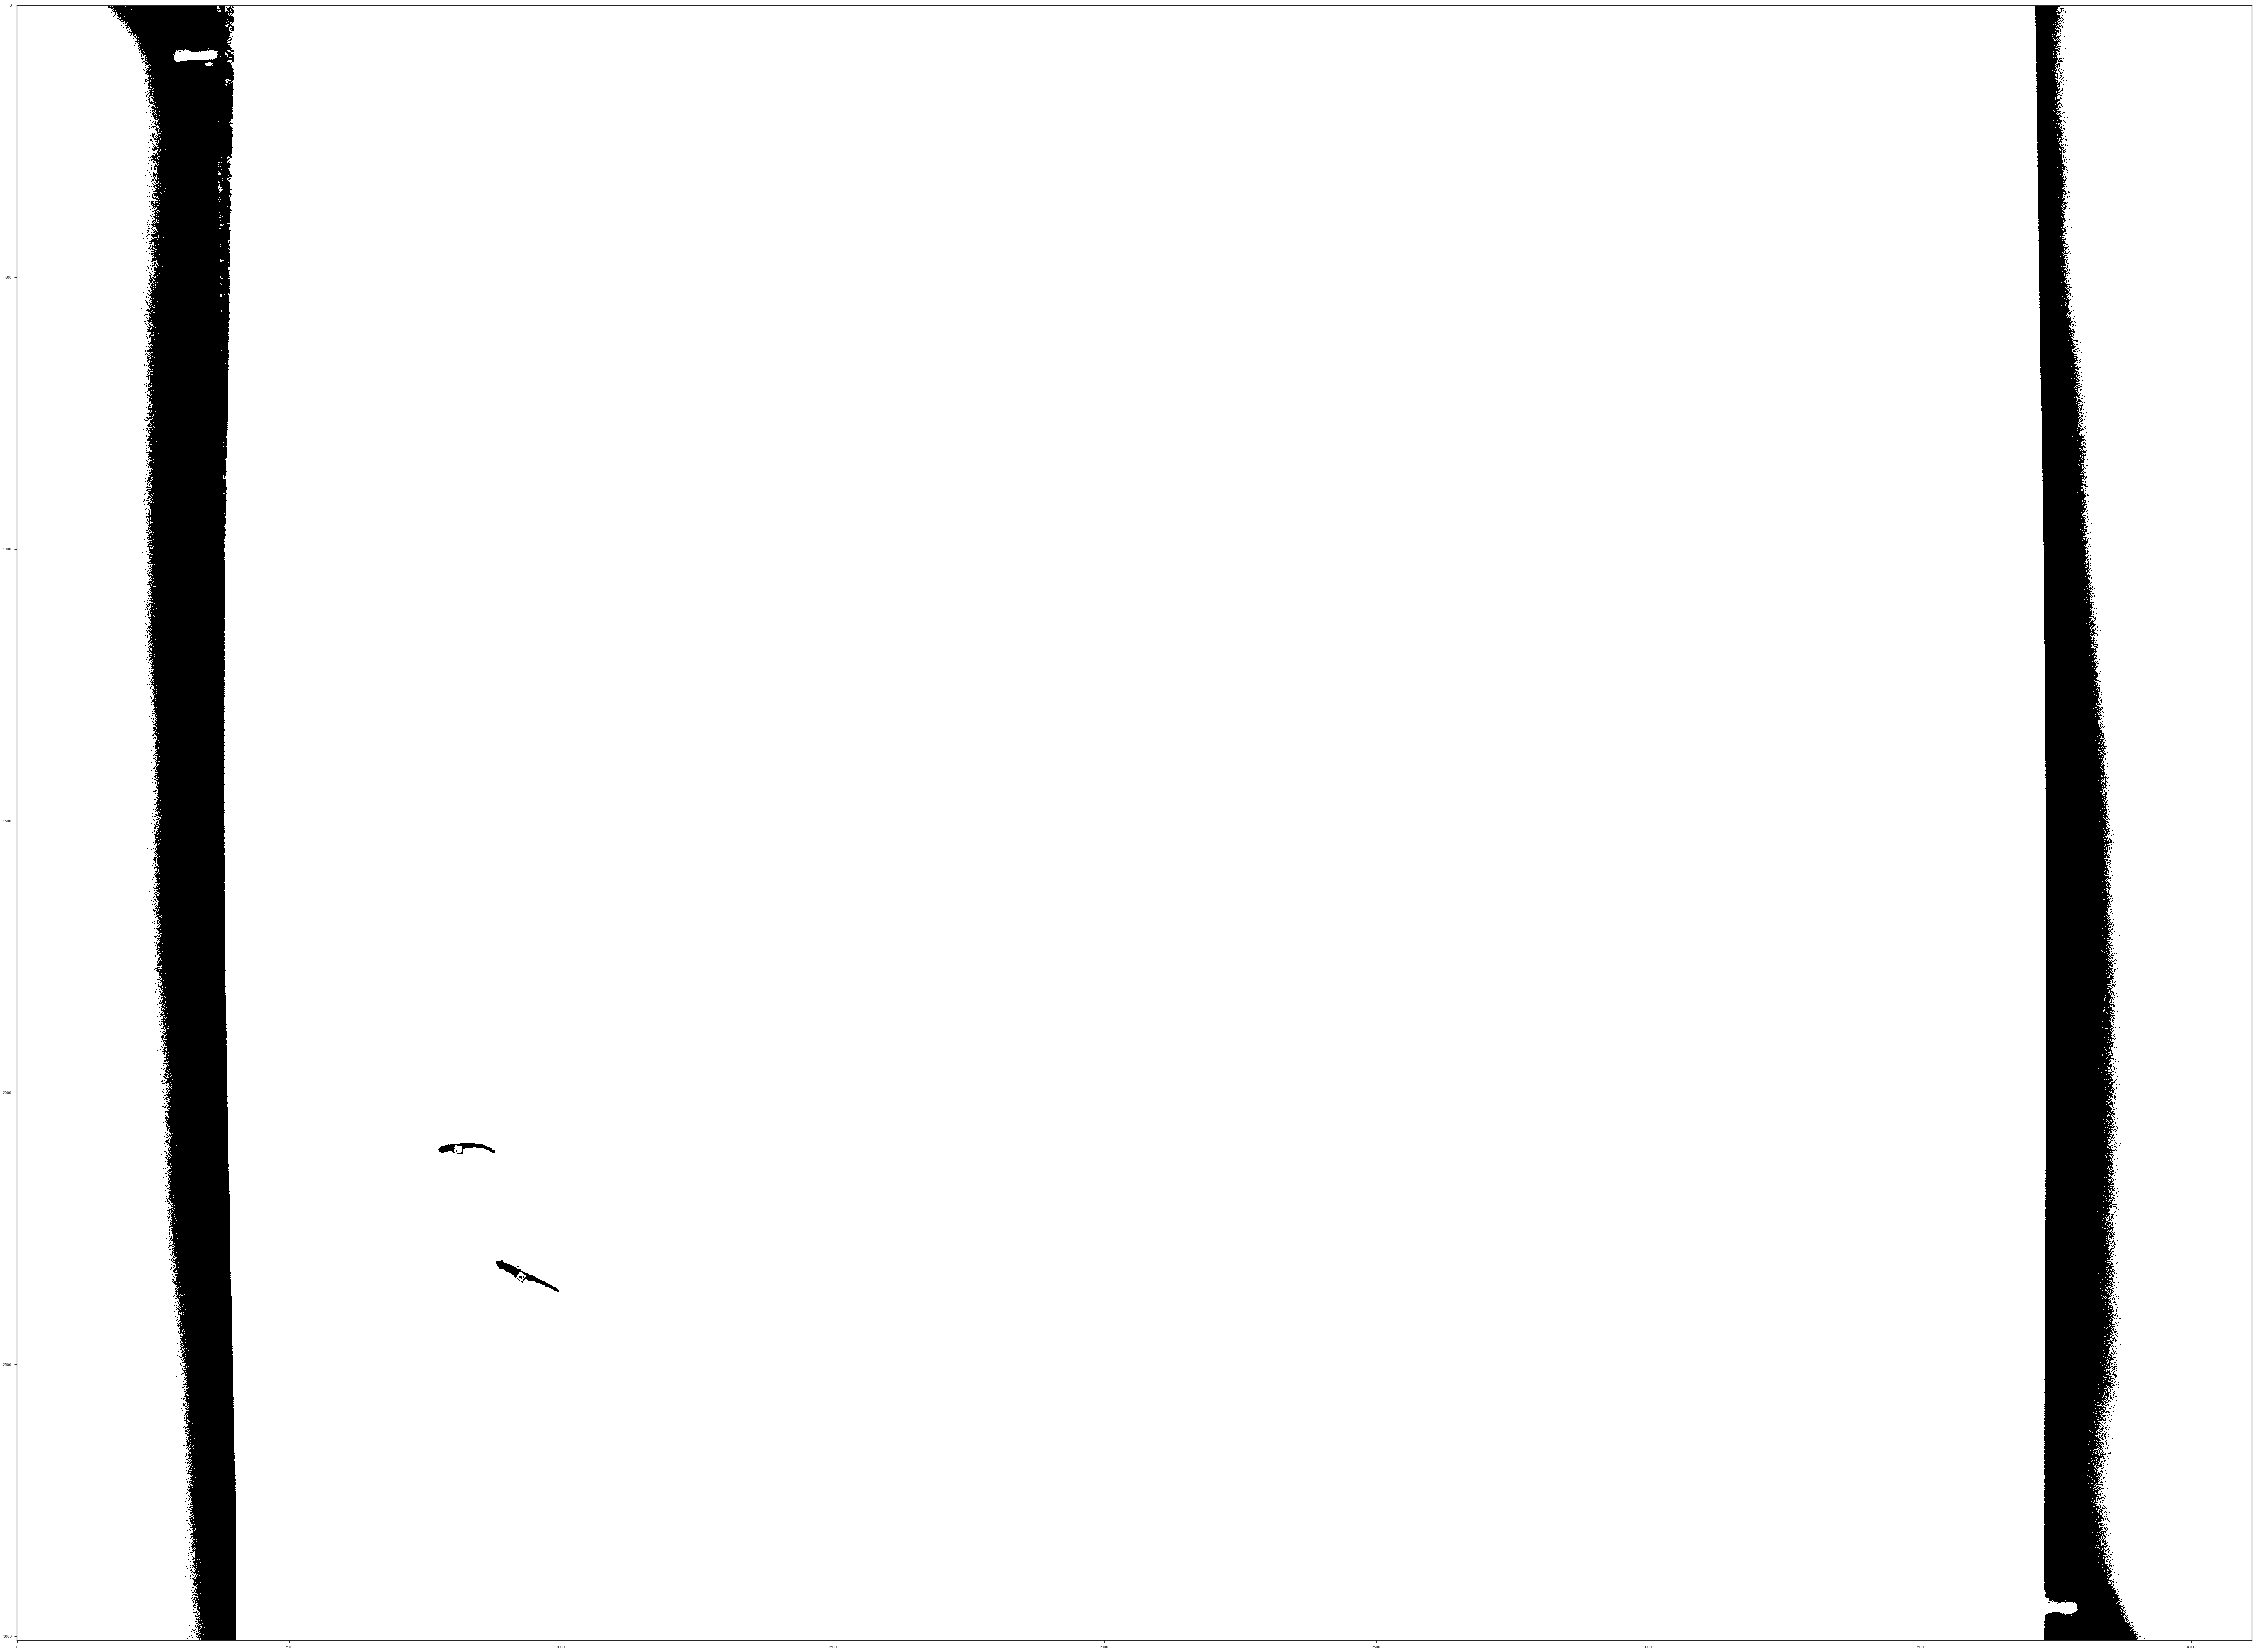

In [15]:
gray = get_grayscale(frame, 'green')
thresh = get_threshold(gray, 1001, 60)
plt.figure(figsize=(100,100))
plt.imshow(thresh, cmap='gray')
plt.show()

In [18]:
cv2.setNumThreads(0)
#pt1 = (1200,800)
#pt2 = (1700,1300)

#cap = cv2.VideoCapture("/home/jake/Downloads/GP050016.MP4") 
#cap = cv2.VideoCapture("/media/jake/Elements/Flock_1/Aug27_F1PM_QR/GOPR0182.MP4") 
#cap = cv2.VideoCapture("/media/jake/Elements/2016-11-29-F1PM-QR/GP040484.MP4") 
#cap = cv2.VideoCapture("/home/jake/Downloads/Zebra Finch Codes (Tests)/Black_code_Test.MP4")
#cap = cv2.VideoCapture("/home/jake/Downloads/Zebra Finch Codes (Tests)/GOPR0674.MP4") 
#cap = cv2.VideoCapture("/home/jake/Downloads/Flock_1_Codes_test.MP4") 
#cap = cv2.VideoCapture("/media/jake/My Book/20161209_104048.nvenc-slow-yuv420-gray.mp4") 
#cap = cv2.VideoCapture("/Users/jake/Google Drive/taggedfish/seven_sunbleak_alone.mp4") 
cap = cv2.VideoCapture("/Users/jake/Downloads/pilot15_2jakebarcodedfish_gain3_exposure1500_2extralights_20170510_113909.libx264-crf10-uf-yuv420-gray.mp4")

#cap.set(cv2.CAP_PROP_POS_FRAMES,0)
#cap.set(cv2.CAP_PROP_POS_MSEC,0)
            
pt1 = (0,0)
pt2 = (2048,2048)


n_frames = 0

best_values = []
ID_list = []
#approx_list = []
matched_list = []
area_list = []
peri_list = []
periratio_list = []
periarea_list = []
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc('A','V','C','1')
out = cv2.VideoWriter('output.mp4',fourcc, 29.0, (4112,3008), True)
#out = cv2.VideoWriter('output.mp4',fourcc, 90.0, (2160, 2160), True)

out.set(cv2.VIDEOWRITER_PROP_QUALITY, 100)
t0 = dt.datetime.now()
cv2.namedWindow("Video")
cv2.namedWindow("thresh")
font = cv2.FONT_HERSHEY_SIMPLEX

flat_len = barcode_size[0]*barcode_size[1]   

maxSide = 100
length = maxSide - 1

dst = np.array([
            [0, 0],
            [length, 0],
            [length, length],
            [0, length]], dtype = "float32")

while cap.isOpened():  
    
    ret, image = cap.read()
    
    if ret:
        n_tags = 0
        pixel_values = []
        warped_list = []
        #image = undistort_image(image, calib_params, crop = True)
        #image = crop(image, pt1, pt2)
        #cropped = cv2.resize(cropped, (0,0), None, fx = 0.33, fy = 0.33, interpolation = cv2.INTER_LINEAR)

        #image = cv2.resize(image, (0,0), None, fx = 0.5, fy = 0.5, interpolation = cv2.INTER_AREA)
        

        display_img = image.copy()

        #_, gray, _ = cv2.split(image)
        gray = get_grayscale(image, channel = 'green')
        gray = cv2.GaussianBlur(gray, (1,1), 1)
        #thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 1001, 0)
        thresh = get_threshold(gray, block_size = 1001, offset = 60)
        #ret, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
        #contour_image, contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = get_contours(thresh)
        #cv2.drawContours(display_img, contours, -1, (0,0,255), 3)
        edge_thresh = 1
        image_shape = image.shape
        maxx_thresh = image_shape[1] - edge_thresh
        maxy_thresh = image_shape[0] - edge_thresh
        
        for cnt in contours:
            
            cnt_shape = cnt.shape

            if cnt_shape[0] >= 4:
                
                area = cv2.contourArea(cnt, True)

                if -10 > area > -20000:
                    
                    cnt_reshape = cnt.reshape((cnt_shape[0], cnt_shape[2]))
                    cnt_x = cnt_reshape[:,0]
                    cnt_y = cnt_reshape[:,1]
                    flat = cnt.flatten()
                    edge_zero = np.sum(flat <= edge_thresh)
                    edge_maxx = np.sum(cnt_x >= maxx_thresh)
                    edge_maxy = np.sum(cnt_y >= maxy_thresh)

                    if edge_zero == 0 and edge_maxx == 0 and edge_maxy == 0:
                        
                        peri_cnt = cv2.arcLength(cnt, True)

                        approx = cv2.approxPolyDP(cnt, 0.1 * peri_cnt, True)
                    
                        #cv2.drawContours(display_img, [approx], -1, (127,0,255), 3)

                        poly_area = cv2.contourArea(approx, True)

                        if len(approx) == 4 and -10 > poly_area > -10000 and cv2.isContourConvex(approx) and 0 < peri_cnt < 1000:
                            peri_approx = cv2.arcLength(approx, True)

                            peri_ratio = peri_cnt/peri_approx
                            periarea = peri_cnt/area
                            
                            #cv2.drawContours(display_img, [cnt], -1, (0,0,255), 2)
                            
                            if -0.5 < periarea <= 0:
                            
                                cv2.drawContours(display_img, [cnt], -1, (0,255,255), 1)

                                peri_approx = cv2.arcLength(approx, True)

                                cnt_shape = approx.shape
                                pts = approx.reshape((cnt_shape[0], cnt_shape[-1]))

                                pts = order_points(pts)
                                (tl, tr, br, bl) = pts
                                
                                
                                #top = distance(tr - tl)
                                #right = distance(br - tr)
                                #bottom = distance(bl - br)
                                #left = distance(tl - bl)
                                                                
                                # compute the perspective transform matrix and then apply it
                                M = cv2.getPerspectiveTransform(pts, dst)
                                warped = cv2.warpPerspective(gray, M, (maxSide, maxSide), borderValue = 255 )
                                #warped = ( warped - warped.mean() ) / warped.std()
                                warped_list.append(warped)
                                resize_warp = cv2.resize(warped, barcode_size, interpolation = cv2.INTER_LINEAR)
                                if resize_warp.std() > 10:
                                    ret,resize_warp = cv2.threshold(resize_warp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
                                    resize_warp[np.array([0,-1]),:] = 255
                                    resize_warp[:,np.array([0,-1])] = 255
                                #resize_warp = ( resize_warp - resize_warp.mean() ) / resize_warp.std()

                                pixel_values.append(resize_warp)

                                correlation = corr2_coeff(barcodes, resize_warp.reshape((1,flat_len)))
                                best_value = np.max(correlation)

                                best_values.append(best_value)
                                area_list.append(area)
                                peri_list.append(peri_cnt)
                                periratio_list.append(peri_ratio)
                                periarea_list.append(peri_cnt/area)
                                
                                if best_value > 0.8:
                                    
                                    
                                    #best_values.append(best_value)
                                    #area_list.append(area)
                                    best_index = np.argmax(correlation)

                                    ID = IDs[best_index]
                                    ID_list.append(ID)
                                    centroid = np.array(pts.mean(0))
                                    y_offset = 0
                                    x_offset = 0
                                    bottom_centroid = tuple((centroid + np.array([x_offset,-1*y_offset])).astype(int))
                                    top_centroid = tuple((centroid + np.array([x_offset,y_offset])).astype(int))
                                    mid_centroid = tuple((centroid + np.array([x_offset,0])).astype(int))
                                    rotate_test = best_index % 4

                                    if rotate_test == 3:
                                        edge = np.array(np.mean([tl, tr], axis = 0))
                                    if rotate_test == 0:
                                        edge = np.array(np.mean([tl, bl], axis = 0))
                                    if rotate_test == 1:
                                        edge = np.array(np.mean([br, bl], axis = 0))
                                    if rotate_test == 2:
                                        edge = np.array(np.mean([br, tr], axis = 0))
                                    cv2.drawContours(display_img, [approx], -1, (0,255,0), 1)

                                    #cv2.circle(display_img,tuple(pts[0]), rad, (255,0,0), -1)
                                    #cv2.circle(display_img,tuple(pts[1]), rad, (0,255,0), -1)
                                    #cv2.circle(display_img,tuple(pts[2]), rad, (0,0,255), -1)
                                    #cv2.circle(display_img,tuple(pts[3]), rad, (255,0,255), -1)

                                    #cv2.circle(display_img,centroid, rad, (0,255,0), -1)
                                    edge[1] = -edge[1]
                                    centroid[1] = -centroid[1]
                                    vector = np.subtract(edge, centroid)
                                    vector_angle = angle(vector)
                                    #angle_list.append(vector_angle)
                                    angle_str = '%.0f' % vector_angle
                                    bestval_str = '%.2f' % best_value
                                    
                                    cv2.arrowedLine(display_img, tuple(centroid), tuple(edge), (0,0,255), 1, tipLength = 0.5)

                                    font_scale = 1.5
                                    outline_font = 5
                                    inline_font = 2


                                    cv2.putText(display_img,str(ID),mid_centroid, font, font_scale,(0,0,0),outline_font,cv2.LINE_AA)
                                    cv2.putText(display_img,str(ID),mid_centroid, font, font_scale,(255,255,255),inline_font,cv2.LINE_AA)

                                    #cv2.putText(display_img,"ID: " + str(ID),top_centroid, font, font_scale,(0,0,0),outline_font,cv2.LINE_AA)
                                    #cv2.putText(display_img,"ID: " + str(ID),top_centroid, font, font_scale,(255,255,255),inline_font,cv2.LINE_AA)

                                    #cv2.putText(display_img,"O: " + angle_str, mid_centroid, font, font_scale, (0,0,0),outline_font,cv2.LINE_AA)
                                    #cv2.putText(display_img,"O: " + angle_str, mid_centroid, font, font_scale, (255,255,255),inline_font,cv2.LINE_AA)

                                    #cv2.putText(display_img,"C: " + bestval_str, bottom_centroid, font, font_scale, (0,0,0),outline_font,cv2.LINE_AA)
                                    #cv2.putText(display_img,"C: " + bestval_str, bottom_centroid, font, font_scale, (255,255,255),inline_font,cv2.LINE_AA)

                                    n_tags += 1
                                    
        pixel_values = np.array(pixel_values)

        cv2.putText(display_img,"Number of Barcodes: " + str(n_tags),(30,50), font, 1,(0,0,0),15,cv2.LINE_AA)
        cv2.putText(display_img,"Number of Barcodes: " + str(n_tags),(30,50), font, 1,(255,255,255),3,cv2.LINE_AA)
        
        #display_img = cv2.resize(display_img, (1960,1080), None)

        #display_img = cv2.resize(display_img, (1440,810), None)
        #display_img = cv2.resize(display_img, (2160,2160), None)

        #display_img = cv2.resize(display_img, (0,0), None, fx = 2, fy = 2)
        #thresh = cv2.resize(thresh, (0,0), None, fx = 2, fy = 2)

        #thresh = cv2.resize(thresh, (2160,2160), None)

        #thresh = cv2.resize(thresh, (1440,810), None)
        #thresh = cv2.resize(thresh, (1960,1080), None)

        #thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
        #display_img[-1000:,:] = thresh[:1000,:]
        thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
        #display_img = np.concatenate((display_img, thresh))
        out.write(display_img)
        
        #display_img = cv2.resize(display_img, (0,0), None, fx = 0.5, fy = 0.5, )

        #cv2.imshow('Video', display_img)
        #cv2.imshow('gray', gray)
        #cv2.imshow("thresh", thresh)
        n_frames += 1
        print cap.get(cv2.CAP_PROP_POS_FRAMES)/cap.get(cv2.CAP_PROP_FRAME_COUNT)
    elif cap.get(cv2.CAP_PROP_POS_FRAMES) == cap.get(cv2.CAP_PROP_FRAME_COUNT):
        break
    if cv2.waitKey(1) & 0xFF == 27:
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()
for i in range(5):
    cv2.waitKey(1)
    
t1 = dt.datetime.now()

dtime = t1 - t0
dtime = dtime.total_seconds()
fps = n_frames/dtime

0.0126582278481
0.0253164556962
0.0379746835443
0.0506329113924
0.0632911392405
0.0759493670886
0.0886075949367
0.101265822785
0.113924050633
0.126582278481
0.139240506329
0.151898734177
0.164556962025
0.177215189873
0.189873417722
0.20253164557
0.215189873418
0.227848101266
0.240506329114
0.253164556962
0.26582278481
0.278481012658
0.291139240506
0.303797468354
0.316455696203
0.329113924051
0.341772151899
0.354430379747
0.367088607595
0.379746835443
0.392405063291
0.405063291139
0.417721518987
0.430379746835
0.443037974684
0.455696202532
0.46835443038
0.481012658228
0.493670886076
0.506329113924
0.518987341772
0.53164556962
0.544303797468
0.556962025316
0.569620253165
0.582278481013
0.594936708861
0.607594936709
0.620253164557
0.632911392405
0.645569620253
0.658227848101
0.670886075949
0.683544303797
0.696202531646
0.708860759494
0.721518987342
0.73417721519
0.746835443038
0.759493670886
0.772151898734
0.784810126582
0.79746835443
0.810126582278
0.822784810127
0.835443037975
0.8481012

In [17]:
display_img.shape

(3008, 4112, 3)

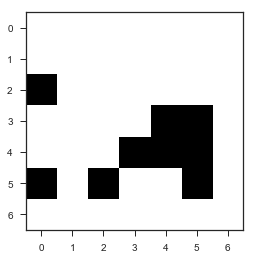

In [93]:
plt.imshow(resize_warp, cmap='gray')
plt.show()

In [37]:
peri_list[0]/4

12.096193999052048

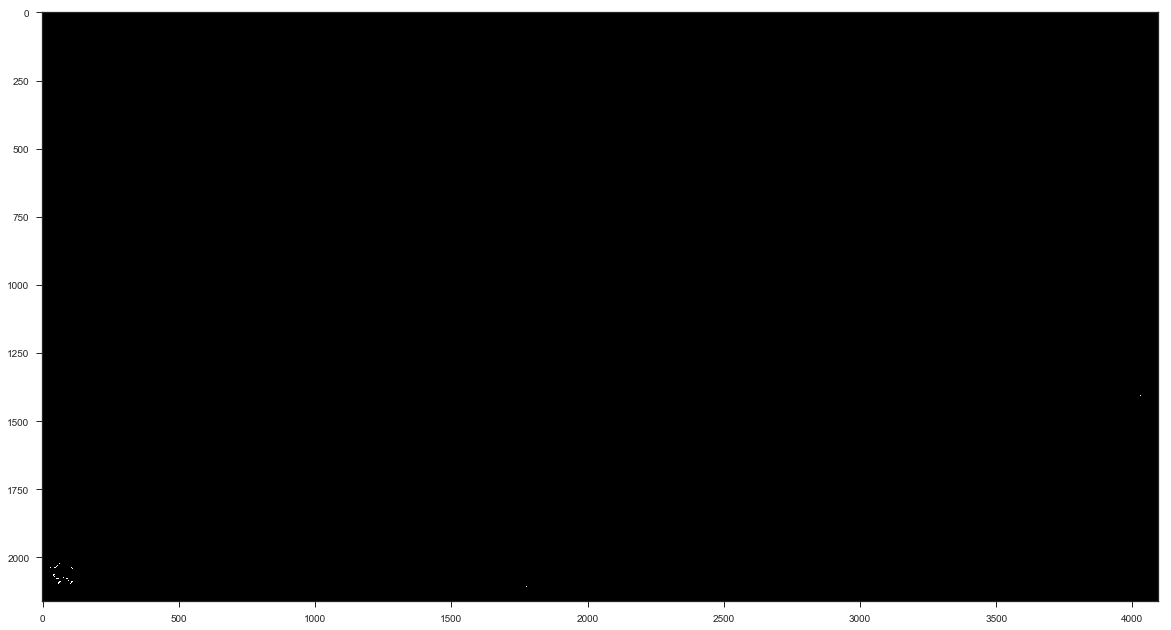

In [29]:
plt.figure(figsize=(20,20))
plt.imshow(thresh, cmap='gray', interpolation='none')
plt.show()

In [25]:
np.array(peri_list)/4

array([  9.0710676 ,  10.68198046,   8.596194  ,  16.81370831,
        18.25304815,  18.6672616 ,  11.04594129,   9.24264061,
        11.94974738,   8.12132031,   9.0710676 ,  10.74264061,
        16.81370828,  18.25304815,  18.52081499,  11.04594144,
         9.24264061,  11.80330077,   9.07106757,  11.03553385,
        16.60660151,  18.10660154,  18.25304809,  11.19238791,
         9.24264061,  12.096194  ,   8.86396083,  10.68198046,
         8.74264061,  16.46015486,  18.10660154,  18.52081501,
        11.04594138,   9.24264061,  12.096194  ,   8.86396083,
        10.68198046,  16.81370825,  18.10660154,  18.52081504,
        11.39949465,   9.24264061,  11.94974738,   8.71751428,
        10.82842708,   8.74264061,  16.66726157,  18.46015492,
        18.6672616 ,  10.83883467,   9.24264061,  11.74264061,
         8.32842708,   8.71751428,  10.88908723,  16.46015483,
        18.25304815,  18.52081493,  11.19238803,   9.24264061,
        11.74264061,   8.32842708,   9.01040751,  11.03

In [49]:
resize_warp.std()

23.848124200973118

In [ ]:
display_img = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,20))
plt.imshow(display_img)

In [19]:
cap = cv2.VideoCapture("/home/jake/Downloads/flock.MP4") 
print cap.get(cv2.CAP_PROP_FRAME_COUNT)
cap.release()

25488.0


In [100]:
print "Frames per second: ", fps
print "Seconds processing per second of video (30 fps): ", dtime/(n_frames/30.)

Frames per second:  3.70152712408
Seconds processing per second of video (30 fps):  8.10476297872


In [180]:
rw_mean = resize_warp.mean()
resize_warp[resize_warp >= rw_mean] = 255
resize_warp[resize_warp < rw_mean] = 0

In [1]:
print best_value
plt.imshow(warped, cmap = 'gray', interpolation = 'none')
plt.show()
plt.imshow(resize_warp, cmap = 'gray', interpolation = 'none')
plt.show()
plt.imshow(barcodes[best_index].reshape(barcode_size), cmap = 'gray', interpolation = 'none')
plt.show()

NameError: name 'best_value' is not defined

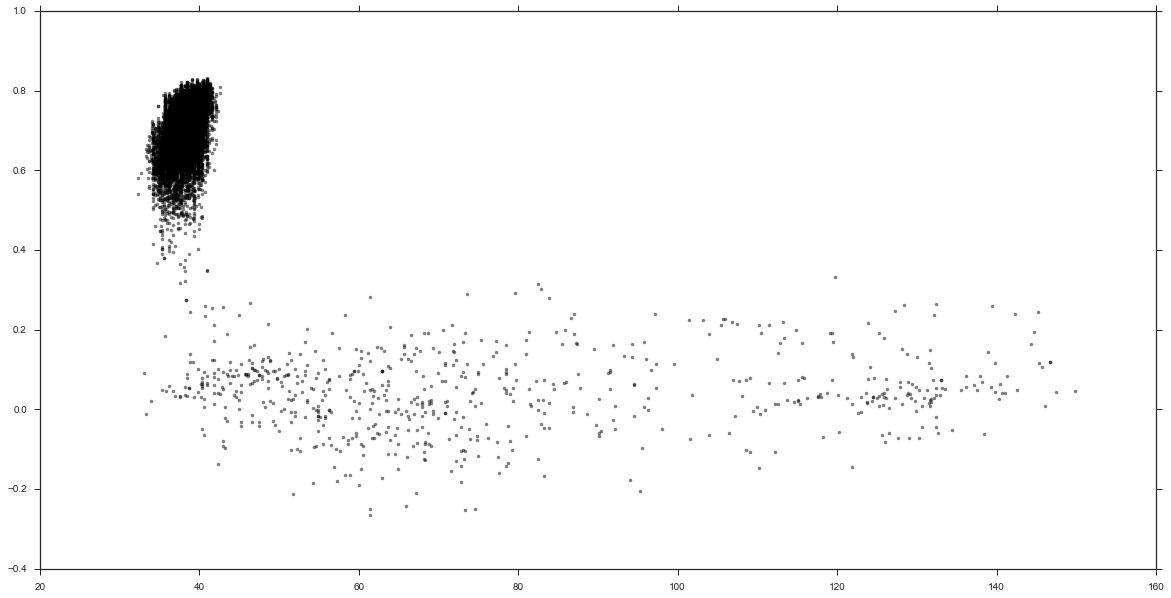

In [182]:
plt.figure(figsize = (20,10))
#plt.plot(np.arange(len(best_values)), best_values, 'k,', alpha = 0.5)
plt.plot(peri_list, best_values, 'k.', alpha = 0.5)

#plt.ylim(0.5,1)
plt.show()

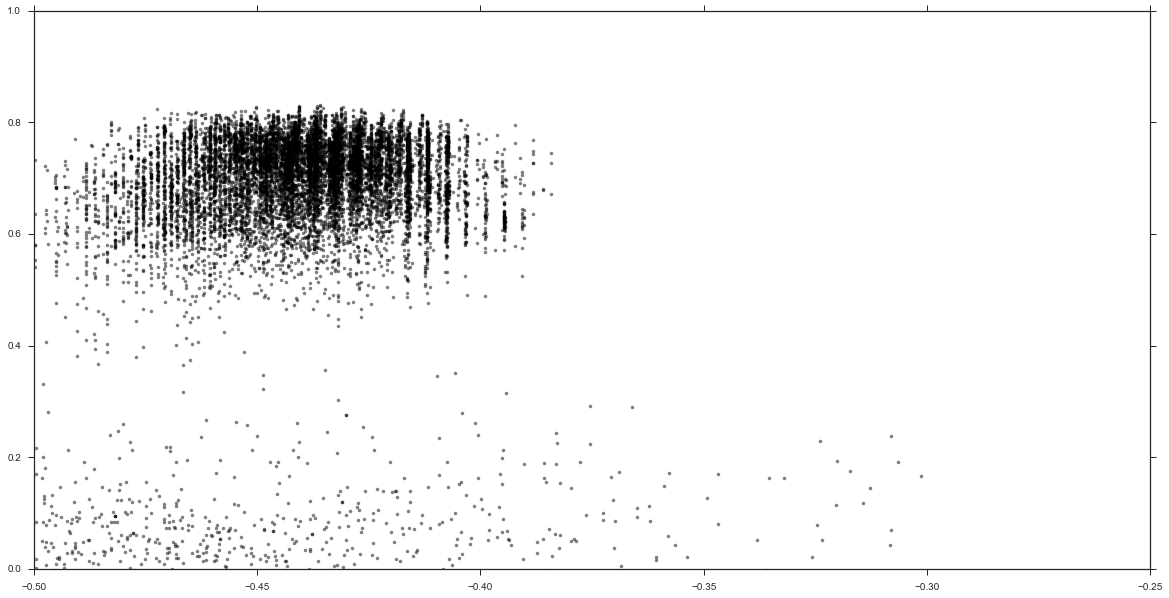

In [183]:
plt.figure(figsize = (20,10))
#plt.plot(np.arange(len(best_values)), best_values, 'k,', alpha = 0.5)
plt.plot(periarea_list, best_values, 'k.', alpha = 0.5)

plt.ylim(0,1)
#plt.xlim(-0.2, 0)
plt.show()

In [45]:
cv2.VIDEOWRITER_PROP_NSTRIPES

3

In [49]:
test_M

array([[ -1.38945470e+00,   5.76115362e-01,   2.93042773e+03],
       [ -4.80805312e-01,  -1.47675917e+00,   4.83391358e+03],
       [ -3.88761451e-04,  -5.20939322e-04,   1.00000000e+00]])

In [50]:
import math

In [59]:
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-1
 
 
# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :
 
    #assert(isRotationMatrix(R))
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

In [60]:
print rotationMatrixToEulerAngles(test_M)

[ -5.20939275e-04   2.64411071e-04  -2.80845104e+00]


In [55]:
test_angle

162.15979856720608

In [12]:
np.unique(ID_list)

array([29, 30, 34, 35, 38, 43, 47, 50, 51, 54, 55, 58, 59])

In [45]:
tag1 = np.array([2]*15 + [1]*10).astype(np.float64)
tag2 = np.array([2]*20 + [1]*5).astype(np.float64)

In [46]:
tag1

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [47]:
tag2

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.])

In [48]:
import scipy.stats as sps

In [49]:
sps.pearsonr(tag1, tag2)

(0.61237243569579458, 0.0011389435144915914)

In [89]:
import pinpoint

In [90]:
pinpoint.__version__

'0.0.1'

In [91]:
pinpoint.__doi__

AttributeError: 'module' object has no attribute '__doi__'

In [97]:
len(set([0,255,1]) - set([255,0]))

1

In [99]:
set(np.unique([0,255]))

{0, 255}

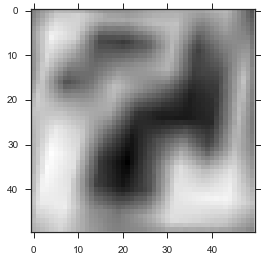

In [75]:
plt.imshow(warped, cmap='gray', interpolation = 'none')

In [43]:
distance(pts[0] - pts[1])

9.2195444

In [46]:
top

9.2195444

In [47]:
right

9.4868326

In [48]:
bottom

8.2462111

In [49]:
left

9.2195444